In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.metrics import AUC
from tensorflow.random import set_seed
from tensorflow.keras import backend as K

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE = 32
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


# Load Data

## tfrecords

In [3]:
# Full path is needed
def get_filenames(filepath):
    return [os.path.join(filepath, file) for file in os.listdir(filepath)]

In [4]:
train_dir = os.path.join(os.getcwd(), 'data', 'train_tfrecords')
test_dir = os.path.join(os.getcwd(), 'data', 'test_tfrecords')

train_dataset = tf.data.TFRecordDataset(get_filenames(train_dir))
test_dataset = tf.data.TFRecordDataset(get_filenames(test_dir))

In [6]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "StudyInstanceUID": tf.io.FixedLenFeature([], tf.string),
        "ETT - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "ETT - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "ETT - Normal": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Incompletely Imaged": tf.io.FixedLenFeature([], tf.int64),
        "NGT - Normal": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Abnormal": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Borderline": tf.io.FixedLenFeature([], tf.int64),
        "CVC - Normal": tf.io.FixedLenFeature([], tf.int64),
        "Swan Ganz Catheter Present": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.io.decode_image(example['image'])
    label = [
        tf.cast(example["ETT - Abnormal"], tf.int32),
        tf.cast(example["ETT - Borderline"], tf.int32),
        tf.cast(example["ETT - Normal"], tf.int32),
        tf.cast(example["NGT - Abnormal"], tf.int32),
        tf.cast(example["NGT - Borderline"], tf.int32),
        tf.cast(example["NGT - Incompletely Imaged"], tf.int32),
        tf.cast(example["NGT - Normal"], tf.int32),
        tf.cast(example["CVC - Abnormal"], tf.int32),
        tf.cast(example["CVC - Borderline"], tf.int32),
        tf.cast(example["CVC - Normal"], tf.int32),
        tf.cast(example["Swan Ganz Catheter Present"], tf.int32)
    ]
    return image, label


def read_unlabeled_tfrecord(example):
    FEATURES = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "StudyInstanceUID": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, FEATURES)
    image = tf.io.decode_image(example['image'])
    
    return image

### Data Visulization

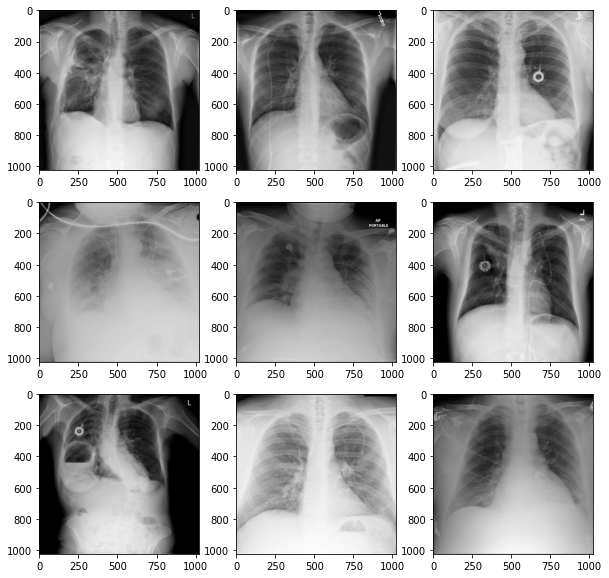

In [8]:
# Train, valid spilit
parsed_train_dataset = train_dataset.map(read_labeled_tfrecord)
train_ds = parsed_train_dataset.skip(4000)
val_ds = parsed_train_dataset.take(4000)

plt.figure(figsize=(10,10))
for i, data in enumerate(train_ds.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
plt.show()

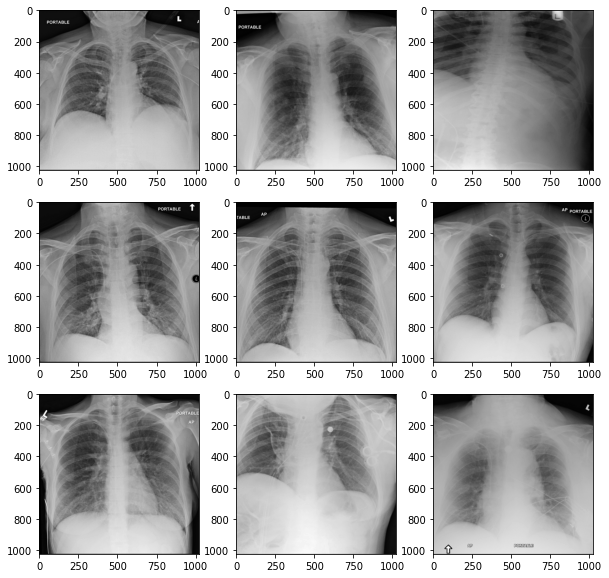

In [18]:
# Test
parsed_test_dataset = test_dataset.map(read_unlabeled_tfrecord)
plt.figure(figsize=(10,10))
for i, data in enumerate(parsed_test_dataset.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data)
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
plt.show()

### Test augmentation

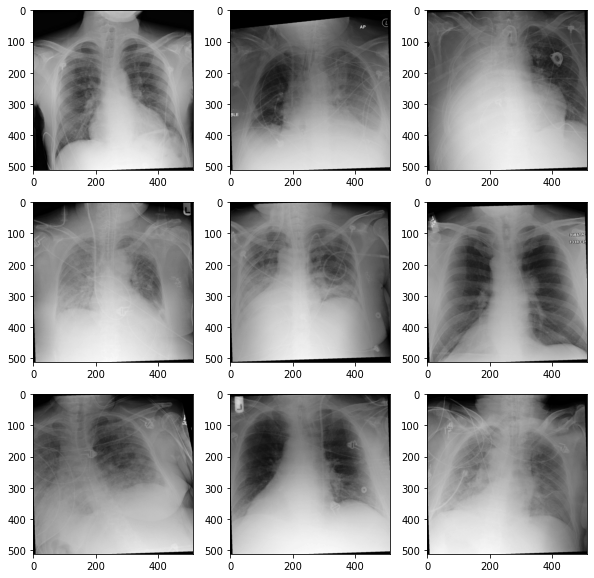

In [125]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tfa.image.rotate(image, random.uniform(-0.2, 0.2))
    
#     image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
#     image = tf.image.random_saturation(image, 0, 2, seed=SEED)
#     image = tf.image.adjust_saturation(image, 3)
    augment = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(512, 512),
        layers.experimental.preprocessing.Rescaling(1. / 255),
        ])
    image = augment(image)
    

    return image, label   

test = val_ds.map(data_augment)


plt.figure(figsize=(10,10))
for i, data in enumerate(test.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
plt.show()

## Image files

In [3]:
load_dir = os.path.join(os.getcwd(), 'data')
df_train = pd.read_csv(load_dir + '/train.csv')
image_paths = load_dir + '/train/' + df_train['StudyInstanceUID'] + '.jpg'

In [4]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image /= 255  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augment(ds):
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])

    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Prefecting on all datasets
    return ds.prefetch(1)

# Load images
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Load labels
label_names = df_train.columns[1:-1]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(df_train[label_names].values, tf.int64))

# Pack images and labels together
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.take(5000)

# Train validation split
ds = ds.shuffle(len(df_train))
train_ds = ds.skip(1000)
val_ds = ds.take(1000)

In [5]:
train_ds = augment(train_ds)
val_ds = val_ds.batch(BATCH_SIZE)

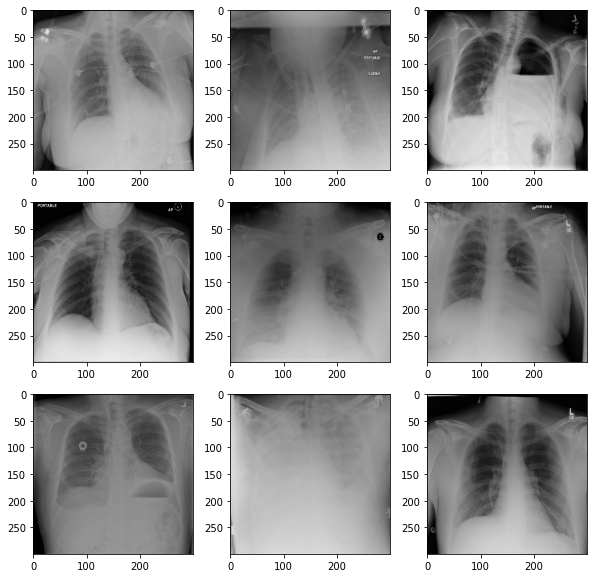

In [6]:
plt.figure(figsize=(10, 10))
for i, image, in enumerate(image_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')
plt.show()

# Model

In [11]:
def build_model(pre_trained_model, num_classes):
    """
    Build model with transfer learning
    """
    # Freeze the weights of the pre-trained layers
    for layer in pre_trained_model.layers:
        layer.trainable = False
    # Extract certain layer
#     last_layer = pre_trained_model.get_layer('conv5_block15_0_relu')
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output
   
    x = layers.GlobalAveragePooling2D()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(pre_trained_model.input, x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=[AUC(multi_label=True)])

    return model


def train_model(model, train_ds, val_ds, save_model=True):
    callbacks = myCallback()
    history = model.fit(train_ds,
                        epochs=100,
                        callbacks=[callbacks],
                        validation_data=val_ds)

    if save_model:
        model.save("Kaggle_cathether_line.h5")
        print(f"Model saved")

    return history


class myCallback(tf.keras.callbacks.Callback):
    """
    Define a Callback class that stops training once accuracy reaches 97.0%
    """
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('auc_1') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
def get_model_memory_usage(batch_size, model):


    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    
    print('{} GB memory is required to train the model'.format(gbytes))


In [9]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                                include_top=False,
                                weights='imagenet')
model = build_model(pre_trained_model, 11)
get_model_memory_usage(BATCH_SIZE, model)

3.58 GB memory is required to train the model


In [12]:
history = train_model(model, train_ds, val_ds)

Epoch 1/100
125/125 [==============================] - 185s 1s/step - loss: 18.8932 - auc_1: 0.4984 - val_loss: 20.4842 - val_auc_1: 0.5080
Epoch 2/100
125/125 [==============================] - 185s 1s/step - loss: 36.6256 - auc_1: 0.4958 - val_loss: 46.4530 - val_auc_1: 0.5000
Epoch 3/100
 70/125 [===============>..............] - ETA: 1:02 - loss: 53.7344 - auc_1: 0.4956

KeyboardInterrupt: 